<a href="https://colab.research.google.com/github/DataMinati/Super-Notebooks-100/blob/main/Geospatial_Analysis_of_Wastes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preparation

In [ ]:
# prepare libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import geopandas as gpd # geo-data processing
import matplotlib.pyplot as plt # exporting of plotted image
import math

pd.set_option('display.max_rows', None)  #we work with datasets with a few hundred rows, this helps debugging

# read in country data, tidy up column names
country_codes = pd.read_csv('/kaggle/input/country-codes-iso-a2a3/countries_codes_and_coordinates.csv').rename(columns={'Alpha-2 code': 'iso_a2', 'Alpha-3 code': 'iso_a3', 'Latitude (average)':'lat', 'Longitude (average)':'lng'})
country_codes.set_index(['iso_a3'])

# read in world map (which only uses iso_a3 codes) and join it to country data (which has iso_a3 AND iso_a2 codes)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).set_index('name').drop('Antarctica')
world.set_index(['iso_a3']).join(country_codes, rsuffix='-B')

# read in the waste data which only has iso_a2 codes 
# TODO: how to dynamically point to most recent file?
filepaths = []
wastebottles = []

for i in range (12 ,2, -1):  # start with most recent, as we need this to scale data markers appropriately
    filepath = '/kaggle/input/plastic-bottle-waste/wastebase_scan_summary_2021' + str(i).zfill(2) + 'F'
    filepaths.append(filepath) # remember the filepath, we will use it later to output the generated image
    wastebottles.append(pd.read_csv(filepath + '.csv'))
    
# define a function to calculate an appropriate size for plot markers
mode = 'normal' #set to 'log' for logarithmic scaling
def plotsize(value, maxvalue, scale):
    size = (value / maxvalue) 
    if(mode == 'log'):
        size = np.log(size + 1) # add one to ensure that log always returns positive
    return size * scale

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.0-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Preparing centre points for countries
A centre point (which we loaded in with the country_codes DF) is useful to plot the markers and lines which will represent our data, in a way which is 'inside' each country.    Note that this point is just a geometric concept, it does not correspond to the capital city or a real landmark.

In [ ]:
countries = gpd.GeoDataFrame(country_codes, geometry=gpd.points_from_xy(country_codes.lng, country_codes.lat)).copy()

# build a second DF with the same countries, but slightly offseting the "centre points" to avoid markers overlapping too much
offset_factor = 1.08
countries_offset = gpd.GeoDataFrame(country_codes, geometry=gpd.points_from_xy(country_codes.lng * offset_factor, country_codes.lat))

## 1. Preparing data about Country of Manufacture

Now we group the data by country of *manufacture* and calculate the total number of waste bottles produced by firms in each country.

We then detect the largest number of bottles in any country, to act as an upper bound for scaling the markers we will plot on the map.

## 2. Preparing data about Country of Detection

We then do a similar exercise to build up a table of number of bottles *detected* (scanned) in each country.    This number will typically different from the number manufactured, given that most countries consume some bottles produced by firms, based in other countries.

## 3. Calculating waste flows between country of manufacture and country of detection

In [ ]:
by_mfr_qtys = []
by_scan_qtys = []
wastelines = []
max_mfr_count = 0

for waste_bottles in wastebottles:
    # 1. make a list of bottle counts by country of production
    by_mfr_qty = waste_bottles[['manufacturer_country','bottle_count']].copy().groupby(['manufacturer_country']).bottle_count.agg(['sum']).rename(columns={'sum': 'qty'})
    by_mfr_qty['iso_a2'] = by_mfr_qty.index.astype(str)
    by_mfr_qtys.append(by_mfr_qty)

    #, using the most recent data set, take the maximum count in a single country, as baseline for scaling map markers
    if max_mfr_count == 0:
        max_mfr_count = by_mfr_qty ['qty'].max()
        
    # 2. make a list of bottle counts by country of detection
    by_scan_qty = waste_bottles[['scan_country','bottle_count']].copy().groupby(['scan_country']).bottle_count.agg(['sum']).rename(columns={'sum': 'qty'})
    by_scan_qty['iso_a2'] = by_scan_qty.index.astype(str)
    by_scan_qtys.append(by_scan_qty)
    
    # 3. calculate waste flows
    # 3.1. to avoid a confusing mess of lines, we remove all rows where the producer and detection country are the same
    waste_flows = waste_bottles.loc[waste_bottles.manufacturer_country != waste_bottles.scan_country]

    # 3.2. we merge this DF with the DFs containing country centres
    start_points = pd.merge(countries[['geometry','iso_a2']], waste_flows[['bottle_count', 'manufacturer_country', 'scan_country', 'product_barcode']], left_on='iso_a2', right_on='manufacturer_country', how='inner')
    end_points = pd.merge(countries_offset[['geometry','iso_a2']], waste_flows[['bottle_count', 'manufacturer_country', 'scan_country', 'product_barcode']], left_on='iso_a2', right_on='scan_country', how='inner')
    start_points.rename(columns={'geometry':'start_point'}, inplace=True)
    end_points.rename(columns={'geometry':'end_point'}, inplace=True)

    # 3.3. we create a GeoPandas DF with the geometry set to a linestring between the mfr_country.centre and scan_country.centre
    from shapely.geometry import LineString
    waste_lines = pd.merge(start_points[['manufacturer_country', 'scan_country', 'product_barcode', 'start_point', 'bottle_count']], end_points[['manufacturer_country', 'scan_country', 'product_barcode', 'end_point']], left_on=['manufacturer_country', 'scan_country', 'product_barcode'], right_on=['manufacturer_country', 'scan_country', 'product_barcode'], how='inner')
    waste_lines['line'] = waste_lines.apply(lambda row: LineString([row['start_point'], row['end_point']]), axis=1)
    waste_lines = waste_lines.set_geometry('line')
    wastelines.append(waste_lines)

# TODO: aggregate by each [mfr_country, scan_country] pair?

## Displaying the Map

Finally we can render the map, and overlay the bottle data on it.

OUTPUT:  wastebase_scan_summary_202112F.png
OUTPUT:  wastebase_scan_summary_202111F.png
OUTPUT:  wastebase_scan_summary_202110F.png
OUTPUT:  wastebase_scan_summary_202109F.png
OUTPUT:  wastebase_scan_summary_202108F.png
OUTPUT:  wastebase_scan_summary_202107F.png
OUTPUT:  wastebase_scan_summary_202106F.png
OUTPUT:  wastebase_scan_summary_202105F.png
OUTPUT:  wastebase_scan_summary_202104F.png
OUTPUT:  wastebase_scan_summary_202103F.png


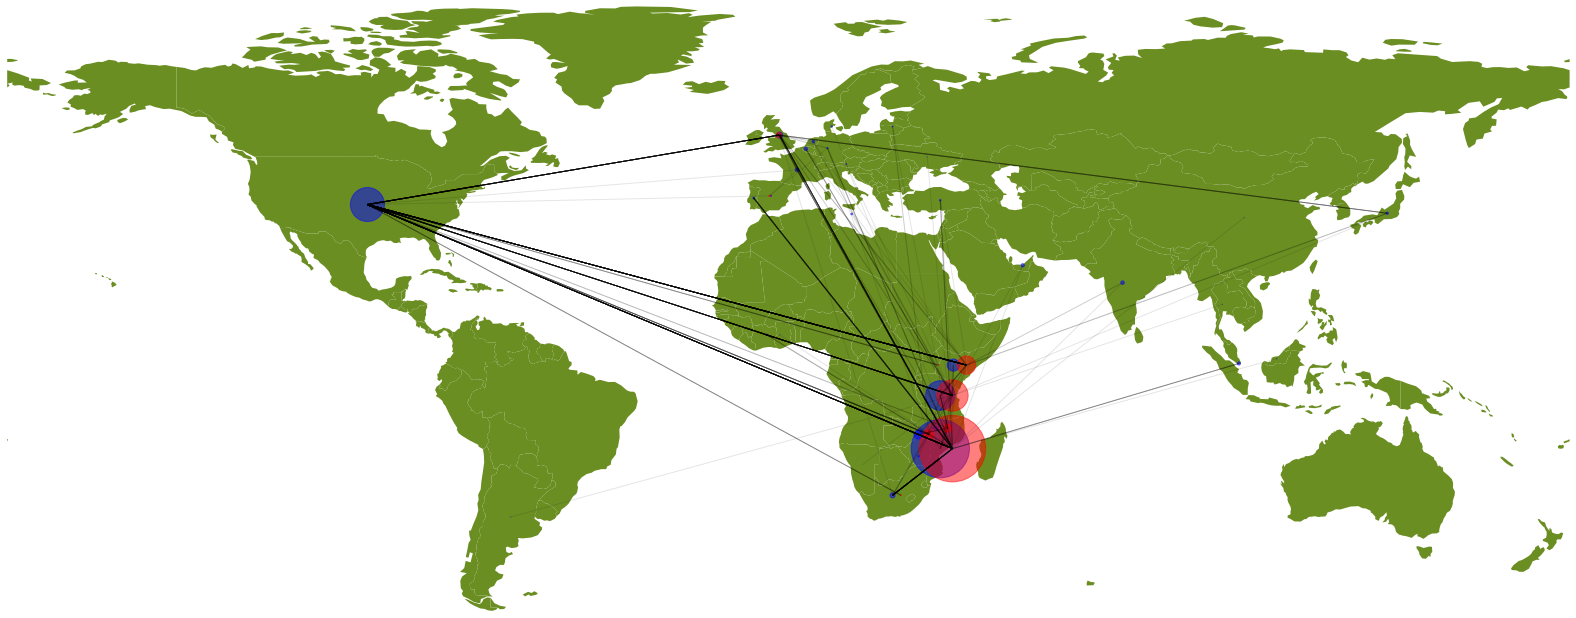

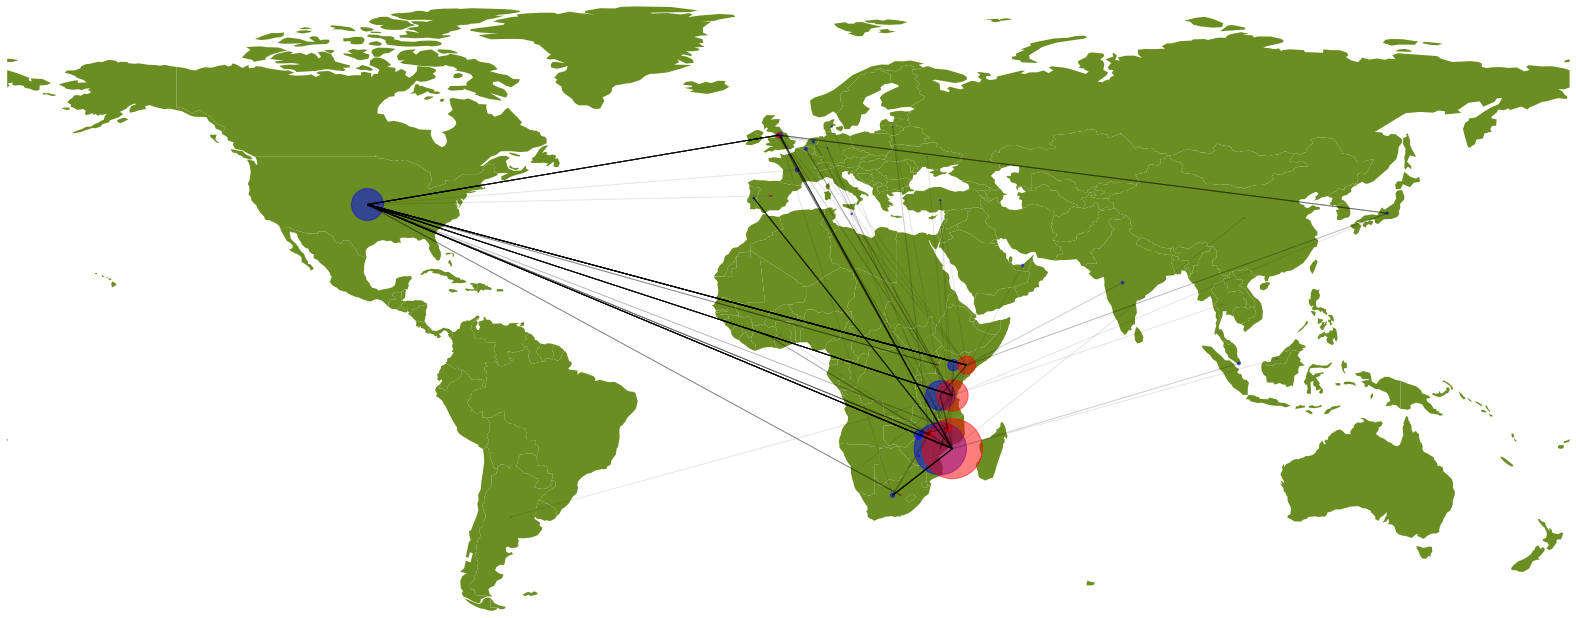

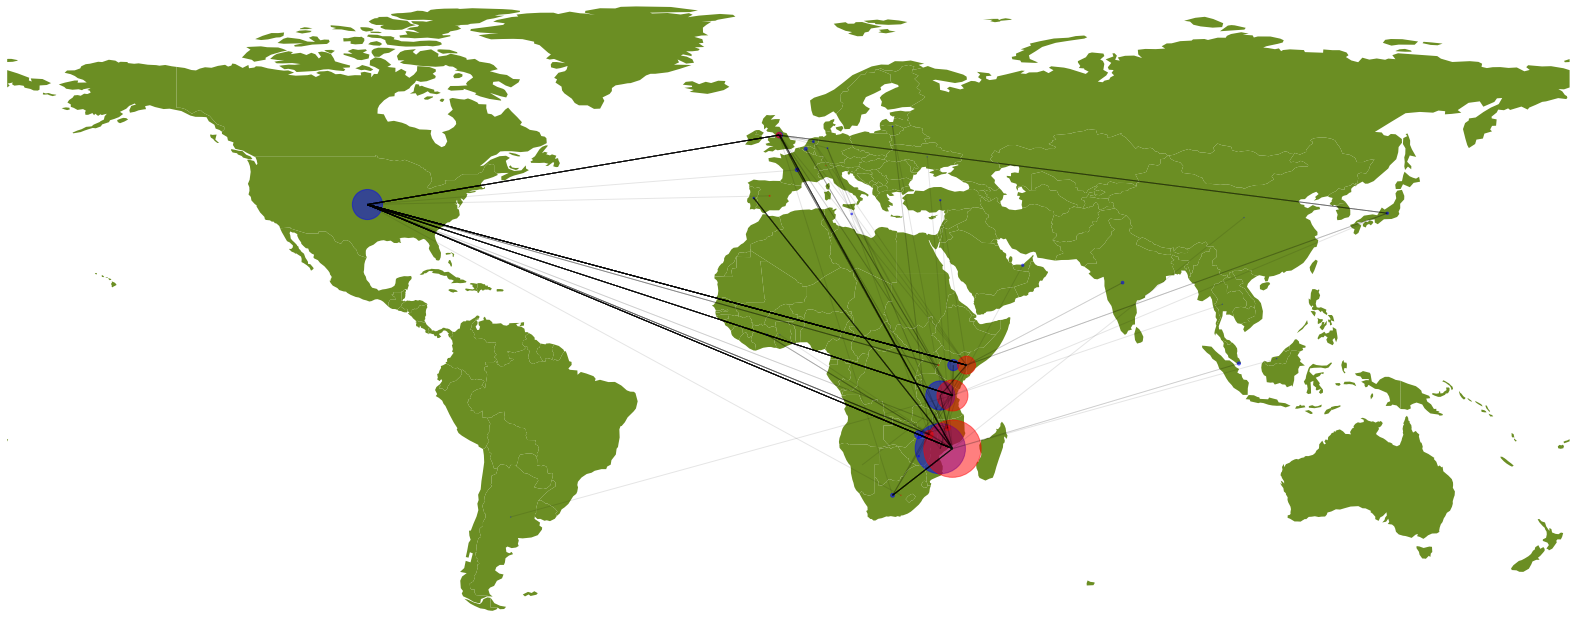

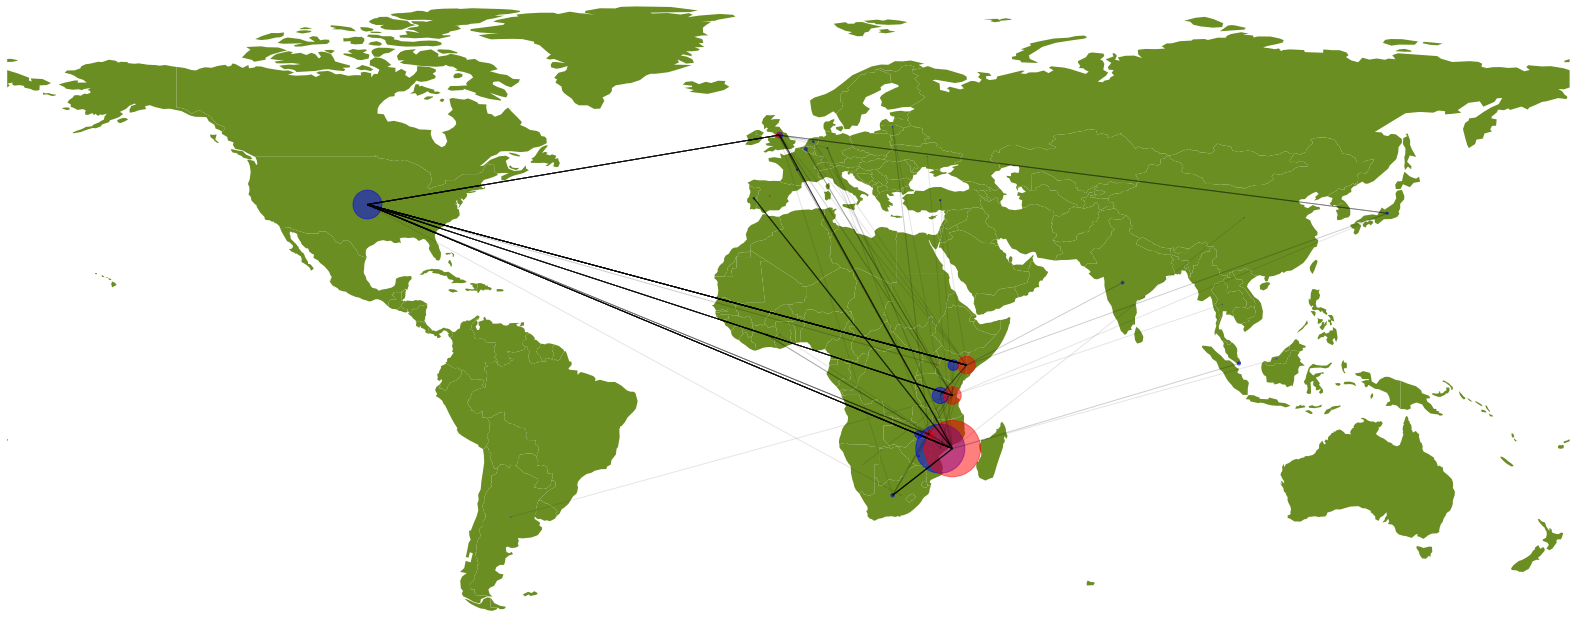

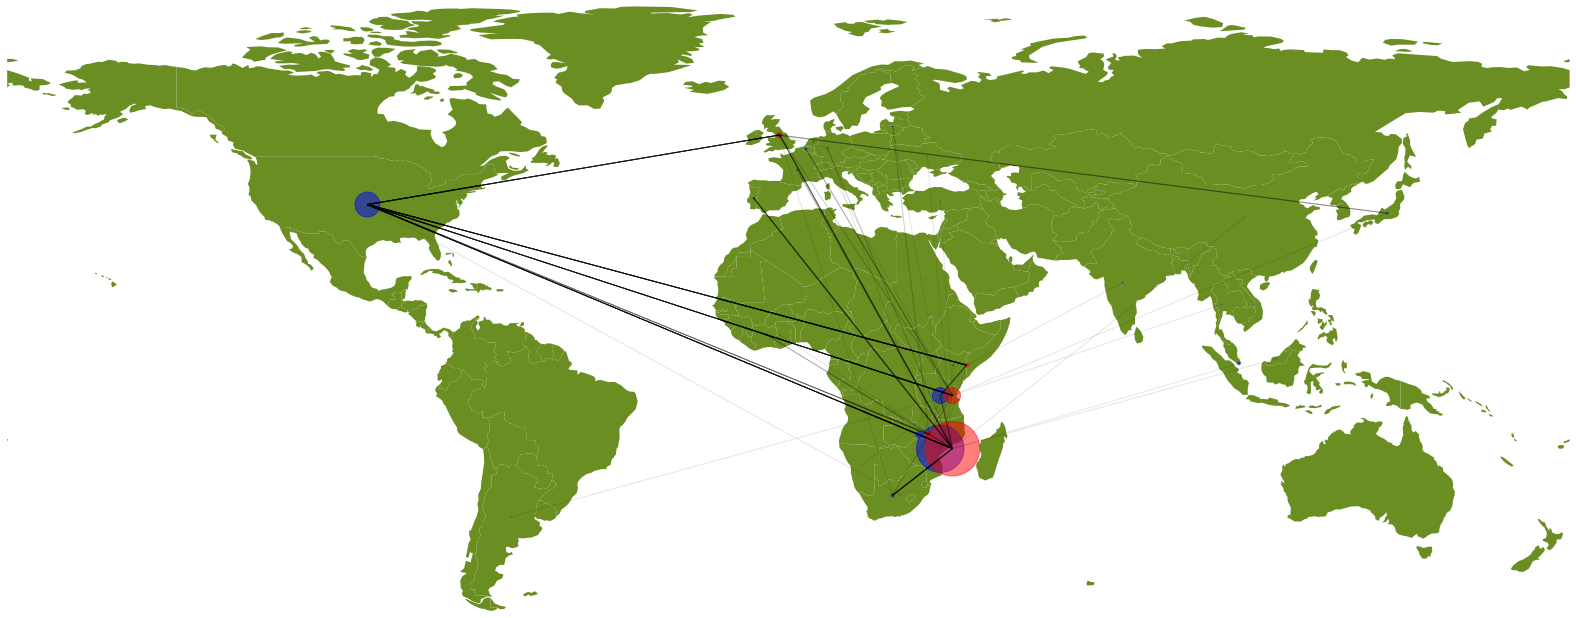

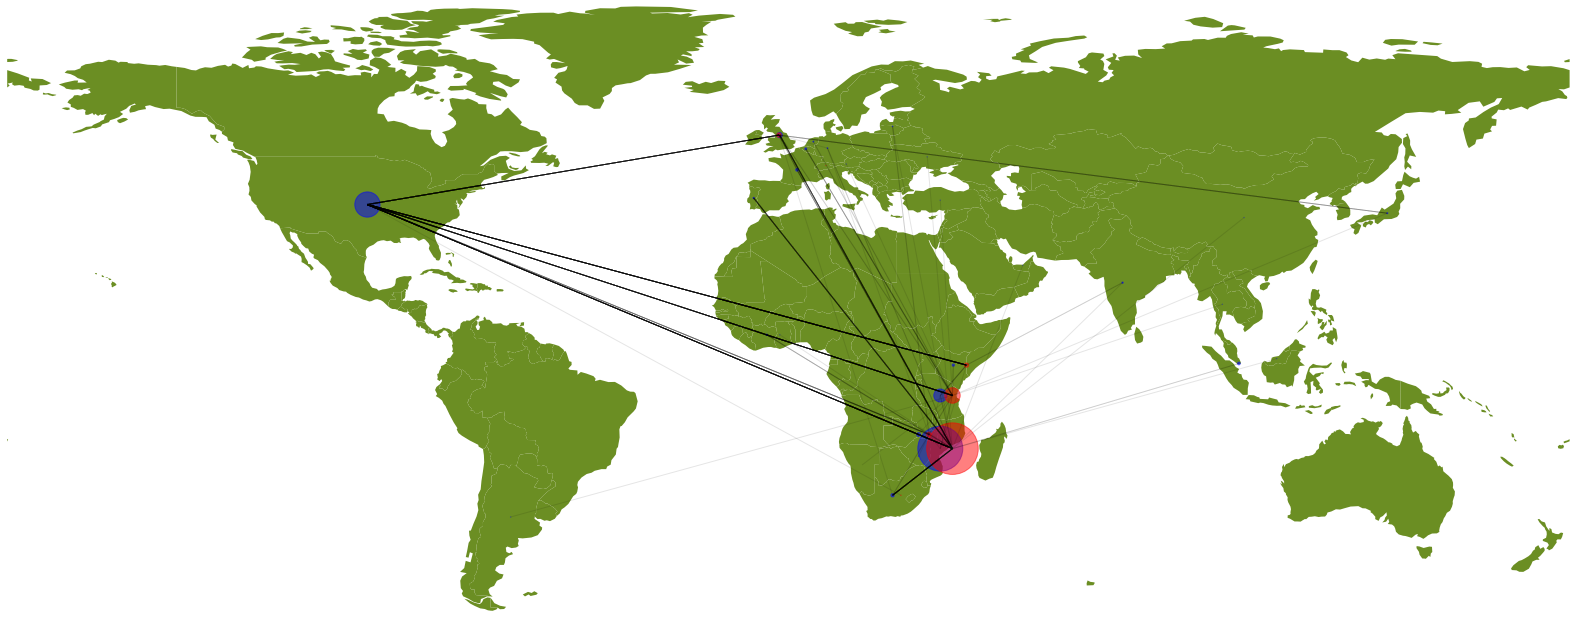

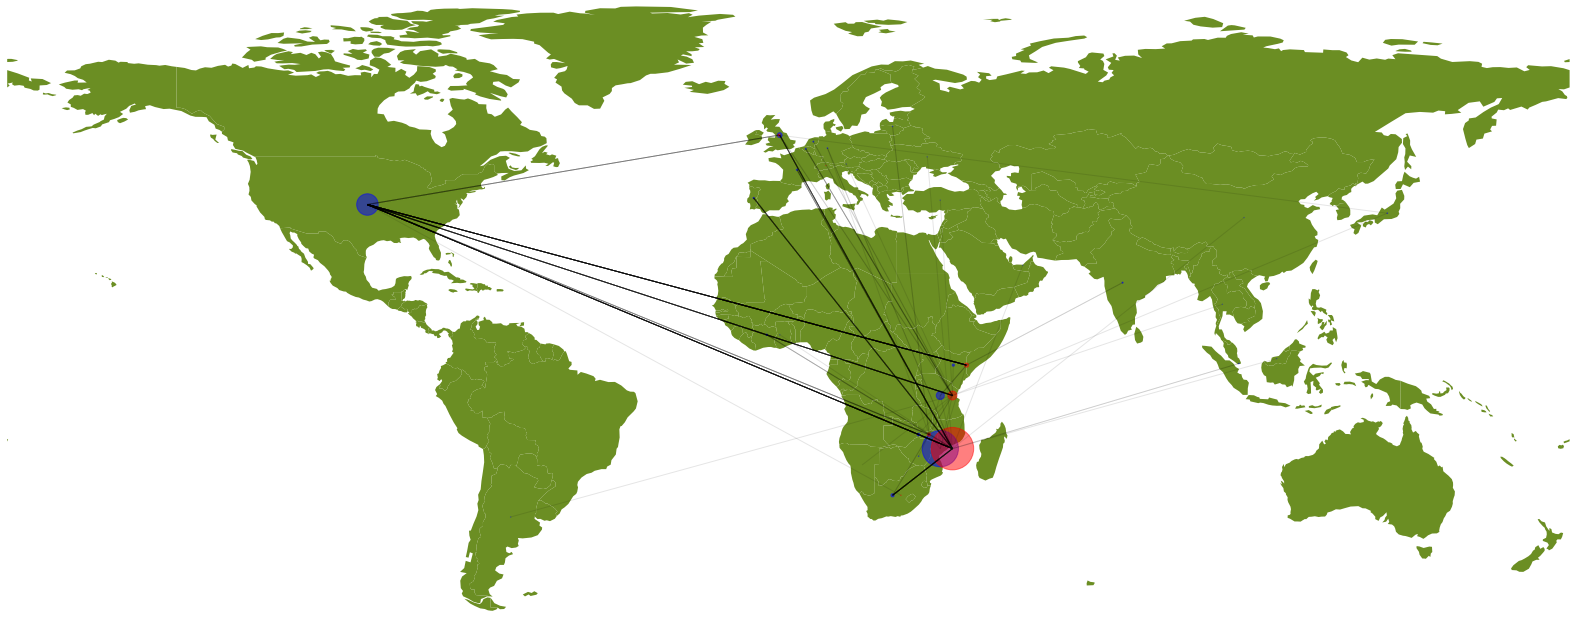

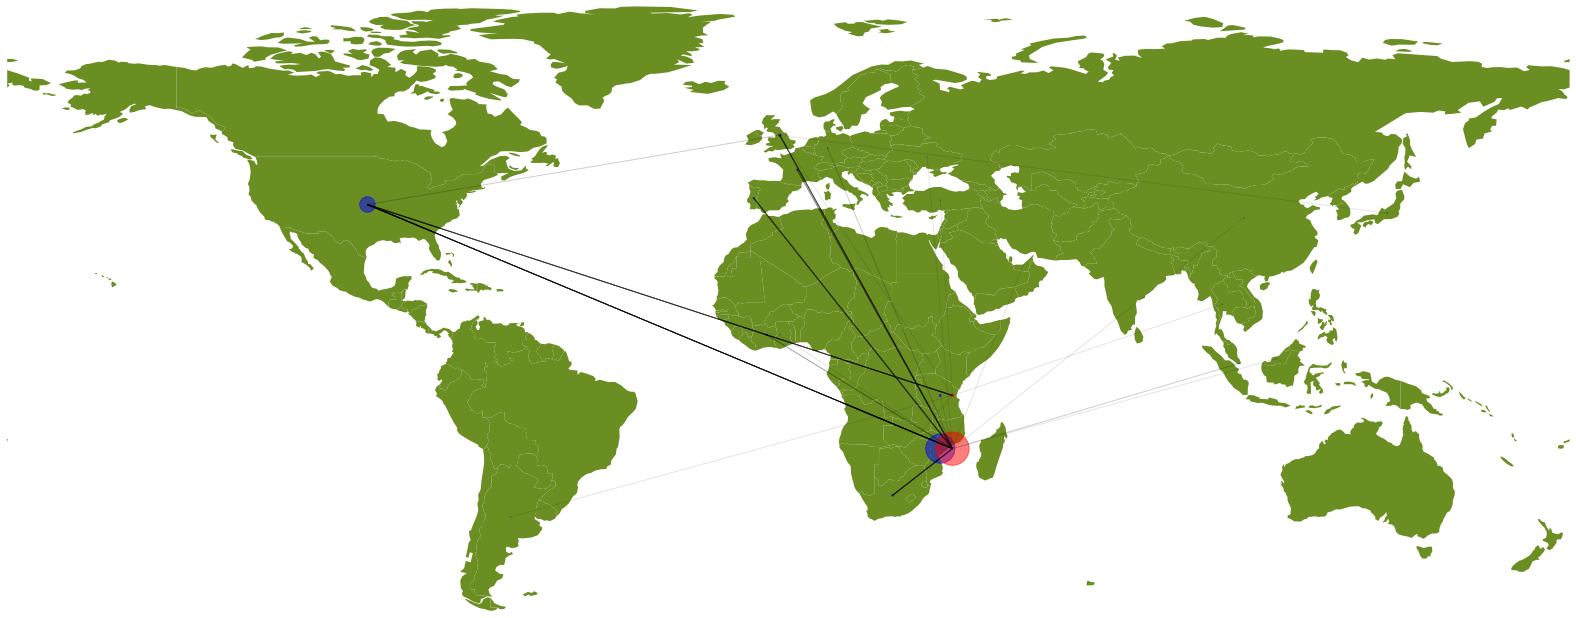

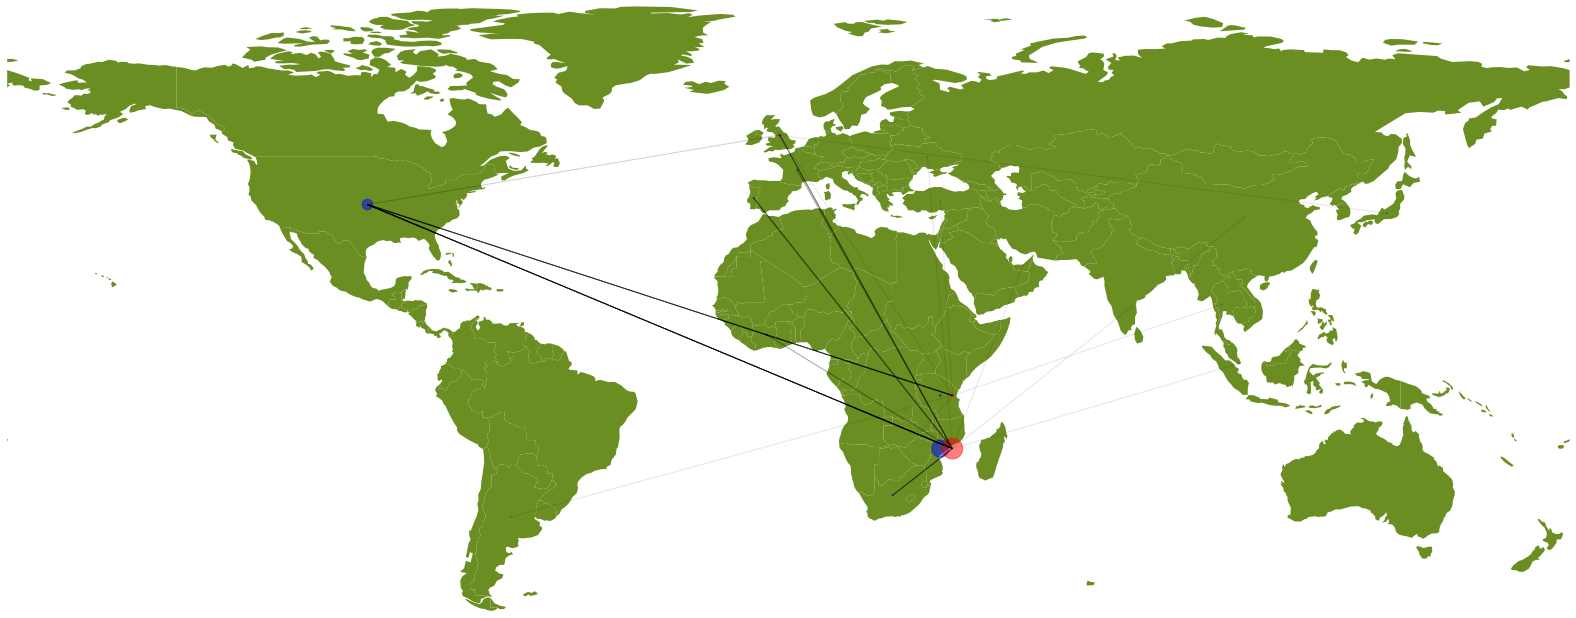

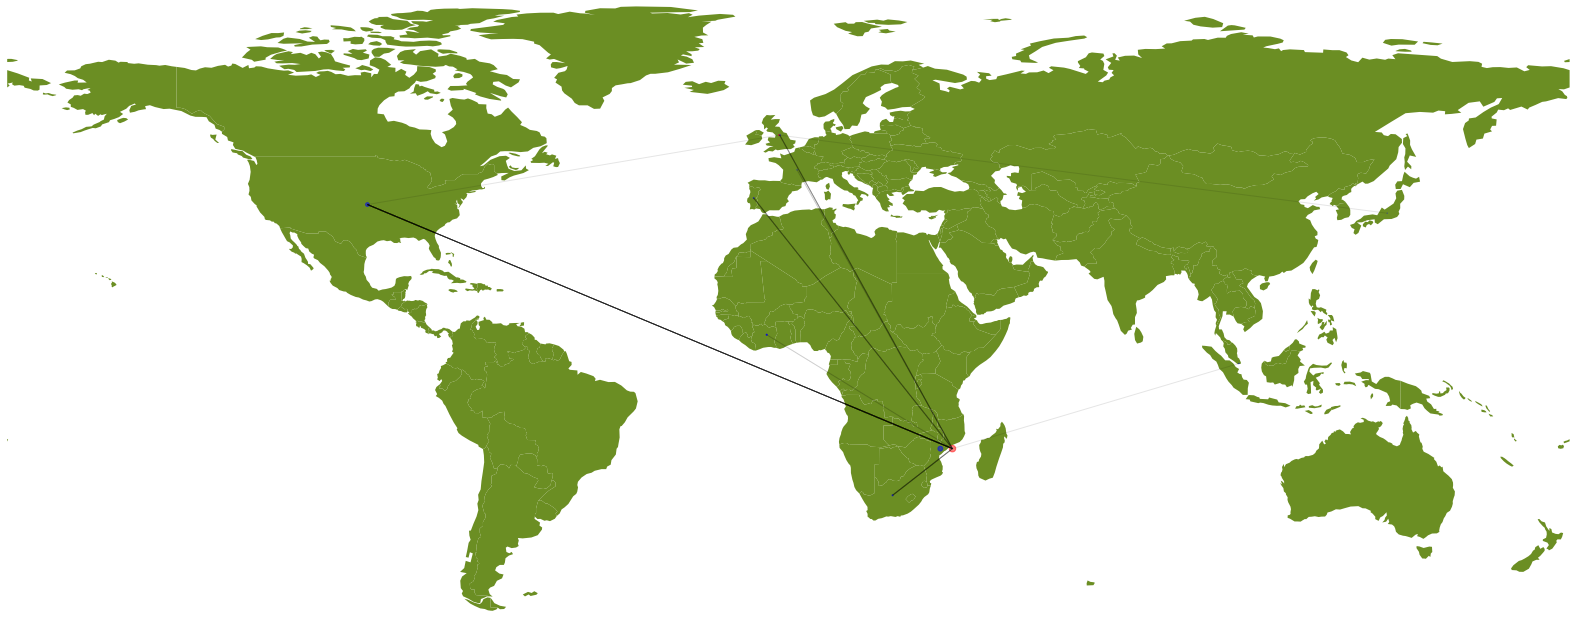

In [ ]:
marker_scale = 3400  # an arbritrary constant, chosen by eye

wastebottles.reverse() # put the list in true chronological order

for i in range(0, len(wastebottles)):   
    # pull the dataframes for the current month, from the lists we prepared in the previous step
    by_mfr_qty = by_mfr_qtys[i]
    by_scan_qty = by_scan_qtys[i]
    waste_lines = wastelines[i]
    
    # merge the scans by manufacturer, with this set of countries, and calculate the marker size proportional to bottle count
    by_mfr = pd.merge(countries, by_mfr_qty,left_on='iso_a2',right_on='iso_a2', how='inner')
    by_mfr['plotsize'] = by_mfr.apply(lambda row: plotsize(row['qty'], max_mfr_count, marker_scale), axis=1)

    # repeat the above for scans by detection
    by_scan = pd.merge(countries_offset, by_scan_qty,left_on='iso_a2',right_on='iso_a2', how='inner')
    by_scan['plotsize'] = by_scan.apply(lambda row: plotsize(row['qty'], max_mfr_count, marker_scale), axis=1)

    # Plot the world map and configure its appearance
    ax = world.plot(figsize=(28,32),color='OliveDrab')
    ax.set_axis_off()
    ax.margins(0)

    # Now overlay the two datasets on the same map
    by_mfr.plot(color='blue', ax=ax, markersize=by_mfr['plotsize'], alpha=0.5)
    by_scan.plot(color='red', ax=ax, markersize=by_scan['plotsize'], alpha=0.5)

    # Finally overlay the flow lines
    waste_lines.plot(color='black', ax=ax, linewidth=1,alpha=0.1)
    
    # Now export the image to a png file - has to be in current directory
    filepath = filepaths[i].split('/')[-1] + '.png'
    print('OUTPUT: ', filepath)
    plt.savefig(filepath, format='png',bbox_inches='tight')